In [58]:
# ______________________ IMPORTS ______________________ #

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [59]:
# ______________________ PREPROCESSING ______________________ #

def preprocess_cabin(df):
    df = df.copy()
    
    # Keep only the first caracter of the 'Cabin' column
    df['Deck'] = df['Cabin'].str[0] if 'Cabin' in df.columns else None

    # Create additional features from Cabin information
    df['Has_Cabin'] = df['Cabin'].notna().astype(int)

    deck_mapping = {
        'A': 'ABC',  # Upper decks
        'B': 'ABC',
        'C': 'ABC',
        'D': 'DE',   # Middle decks
        'E': 'DE',
        'F': 'FG',   # Lower decks
        'G': 'FG',
        'T': 'Other' # Special cases
    }

    df['Deck_category'] = df['Deck'].map(deck_mapping)

    if 'Pclass' in df.columns and 'Fare' in df.columns:
        # Mean of price per class
        fare_means = df.groupby('Pclass')['Fare'].transform('mean')
        # Ratio price paid / mean of class
        df['Fare_ratio'] = df['Fare'] / fare_means
        
        # Estimations based on class and ratio
        conditions = [
            (df['Pclass'] == 1) & (df['Fare_ratio'] > 1.5),
            (df['Pclass'] == 1) & (df['Fare_ratio'] <= 1.5),
            (df['Pclass'] == 2) & (df['Fare_ratio'] > 1.2),
            (df['Pclass'] == 2) & (df['Fare_ratio'] <= 1.2),
            (df['Pclass'] == 3) & (df['Fare_ratio'] > 1),
            (df['Pclass'] == 3) & (df['Fare_ratio'] <= 1)
        ]
        choices = ['ABC', 'DE', 'DE', 'FG', 'FG', 'FG']
        
        # Replace unknown decks by estimations
        df.loc[df['Deck_category'] == 'Unknown', 'Deck_category'] = pd.Series(np.select(conditions, choices, default='Unknown'))
            
        return df
    
def preprocess_title(df):
    df = df.copy()
    
    # Extract title of the name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 
                                     'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    # Group by rare titles
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    return df


def preprocess_age(df):
    df = df.copy()
    
    # Compute mean age by title and class
    age_by_title_class = df.groupby(['Title', 'Pclass'])['Age'].median()
    
    def get_estimated_age(row):
        if pd.isna(row['Age']):
            return age_by_title_class.get((row['Title'], row['Pclass']), 
                   df.groupby('Title')['Age'].median().get(row['Title'],
                   df['Age'].median()))
        return row['Age']
    
    df['Age'] = df.apply(get_estimated_age, axis=1)
    
    return df

def preprocess_family(df):
    df = df.copy()
    
    # Create family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # New column: isAlone
    df.loc[df['FamilySize'] > 1, 'IsAlone'] = 0
    
    # New column: FarePerPerson
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    return df

def preprocess_embarked(df):
    df = df.copy()
    
    # Impute missing values
    df['Embarked'] = df['Embarked'].fillna('S')
    return df

def preprocess(df):
    df = df.drop_duplicates()
    df = preprocess_cabin(df)
    df = preprocess_title(df)
    df = preprocess_age(df)
    df = preprocess_family(df)
    return df

In [60]:
# ______________________ DATASET IMPORT ______________________ #

train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# Preprocess data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Update feature lists to include new cabin-related features
numeric_features = ['Age', 'Fare_ratio', 'FamilySize', 'FarePerPerson']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Deck_category', 'Title']

# Separate features and target
cols_to_drop = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Deck', 'Has_Cabin', 'IsAlone']

X_train = train_data.drop(['Survived'] + cols_to_drop, axis=1)
X_test = test_data.drop(cols_to_drop, axis=1)
y_train = train_data['Survived']

# Convert categorical features to strings
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

In [61]:
# ______________________ RANDOM FOREST ______________________ #

# Create a pipeline with optimal parameters
model_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        bootstrap=True,
        class_weight=None,
        n_estimators=300,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features=None,
        random_state=42
    ))
])

cv_scores_random_forest = cross_val_score(model_random_forest, X_train, y_train, cv=5, scoring='accuracy')
cv_score_random_forest = cv_scores_random_forest.mean().round(4)
print(f"Mean CV score: {cv_score_random_forest}")

model_random_forest.fit(X_train, y_train)

Mean CV score: 0.8485


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Deck_category',
                                                   'Title'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=300,
                                        random_state=42))])

In [72]:
# ______________________ SVM ______________________ #

# Create an imbalanced pipeline
model_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='poly', random_state=42))
])

cv_scores_svm = cross_val_score(model_svm, X_train, y_train, cv=5, scoring='accuracy')
cv_score_svm = cv_scores_svm.mean().round(4)
print(f"Mean CV score: {cv_score_svm}")

model_svm.fit(X_train, y_train)

Mean CV score: 0.8294


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Deck_category',
                                                   'Title'])])),
                ('classifier', SVC(kernel='poly', random_state=42))])

In [63]:
# ______________________ KNN ______________________ #

# Create a pipeline
model_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(algorithm='auto', n_neighbors=9))
])

cv_scores_knn = cross_val_score(model_knn, X_train, y_train, cv=5, scoring='accuracy')
cv_score_knn = cv_scores_knn.mean().round(4)
print(f"Mean CV score: {cv_score_knn}")

model_knn.fit(X_train, y_train)

Mean CV score: 0.817


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Deck_category',
                                                   'Title'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=9))])

In [64]:
# ______________________ XGBoost ______________________ #

# Create a pipeline
model_xgboost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        colsample_bytree=1.0,
        gamma=0.1,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=1,
        n_estimators=200,
        reg_alpha=0.1,
        reg_lambda=1,
        subsample=0.9
    ))
])

cv_scores_xgboost = cross_val_score(model_xgboost, X_train, y_train, cv=5, scoring='accuracy')
cv_score_xgboost = cv_scores_xgboost.mean().round(4)
print(f"Mean CV score: {cv_score_xgboost}")

model_xgboost.fit(X_train, y_train)

Mean CV score: 0.8361


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pcl...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [65]:
# ______________________ AdaBoost ______________________ #

# Create a pipeline
model_adaboost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(algorithm='SAMME.R', n_estimators=200, learning_rate=1.0, random_state=42))
])

cv_scores_ada = cross_val_score(model_adaboost, X_train, y_train, cv=5)
cv_score_ada = cv_scores_ada.mean().round(4)
print(f"Mean CV score: {cv_score_ada}")

model_adaboost.fit(X_train, y_train)

Mean CV score: 0.8339


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Deck_category',
                                                   'Title'])])),
                ('classifier',
                 AdaBoostClassifier(n_estimators=200, random_state=42))])

In [66]:
# ______________________ Neural Network SMOTE ______________________ #

# Create a pipeline
model_nn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(
        k_neighbors=3,
        random_state=42
    )),
    ('classifier', MLPClassifier(
        activation='relu',
        alpha=0.001,
        batch_size=32,
        early_stopping=True,
        hidden_layer_sizes=(256, 128),
        learning_rate='constant',
        learning_rate_init=0.01,
        max_iter=200,
        n_iter_no_change=20,
        solver='adam',
        validation_fraction=0.1
    ))
])

cv_scores_nn = cross_val_score(model_nn, X_train, y_train, cv=5, scoring='accuracy')
cv_score_nn = cv_scores_nn.mean().round(4)
print(f"Mean CV score: {cv_score_nn}")

model_nn.fit(X_train, y_train)

Mean CV score: 0.8171


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Deck_category',
                                                   'Title'])])),
                ('smote', SMOTE(k_neighbors=3, random_state=42)),
                ('classifier',
                 MLPClassifier(alpha=0.001, batch_size=32, early_stopping=True,
                               hidden_layer_sizes=(256, 128),
                               learning_rate_init=0.01, n_iter_no_change=20))])

In [67]:
# ______________________ LightGBM ______________________ #

# Create a pipeline
model_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, colsample_bytree= 0.8, min_child_samples=20, num_leaves=31, subsample=0.8))
])

cv_scores_lgbm = cross_val_score(model_lgbm, X_train, y_train, cv=5, scoring='accuracy')
cv_score_lgbm = cv_scores_lgbm.mean().round(4)
print(f"Mean CV score: {cv_score_lgbm}")

model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare_ratio',
                                                   'FamilySize',
                                                   'FarePerPerson']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='most_frequent',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Deck_category',
                                                   'Title'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=5,
                                subsample=0.8))])

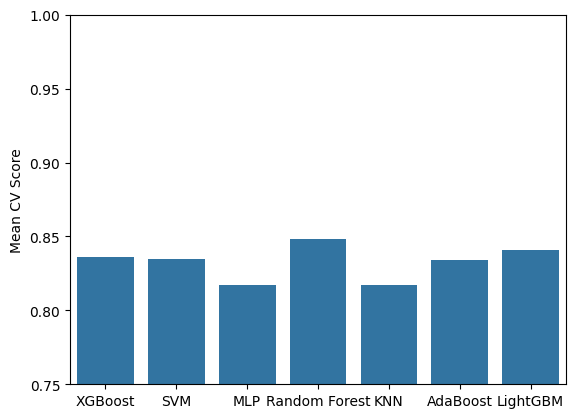

In [68]:
# ______________________ Comparison ______________________ #

# plot the mean CV scores
sns.barplot(x=['XGBoost', 'SVM', 'MLP', 'Random Forest', 'KNN', 'AdaBoost', 'LightGBM'], y=[cv_score_xgboost, cv_score_svm, cv_score_nn, cv_score_random_forest, cv_score_knn, cv_score_ada, cv_score_lgbm])
plt.ylabel('Mean CV Score')
plt.ylim(0.75, 1.0)
plt.show()
